# Chapter 10 — Deployment & Optimization

In [8]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")

    # Install from PyPI — avoids torch index conflicts in local pyproject.toml
    !pip install -q librosa soundfile matplotlib neucodec vieneu

    # Clone VieNeu-TTS for model weights, configs, and vieneu_utils
    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import os

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. Quantization: How Q4 Compresses the Model

Linear quantization maps float weights to integers:
$$q = \text{round}\left(\frac{x - x_{\min}}{x_{\max} - x_{\min}} \cdot (2^b - 1)\right), \quad x_{\text{approx}} = q \cdot s + x_{\min}$$

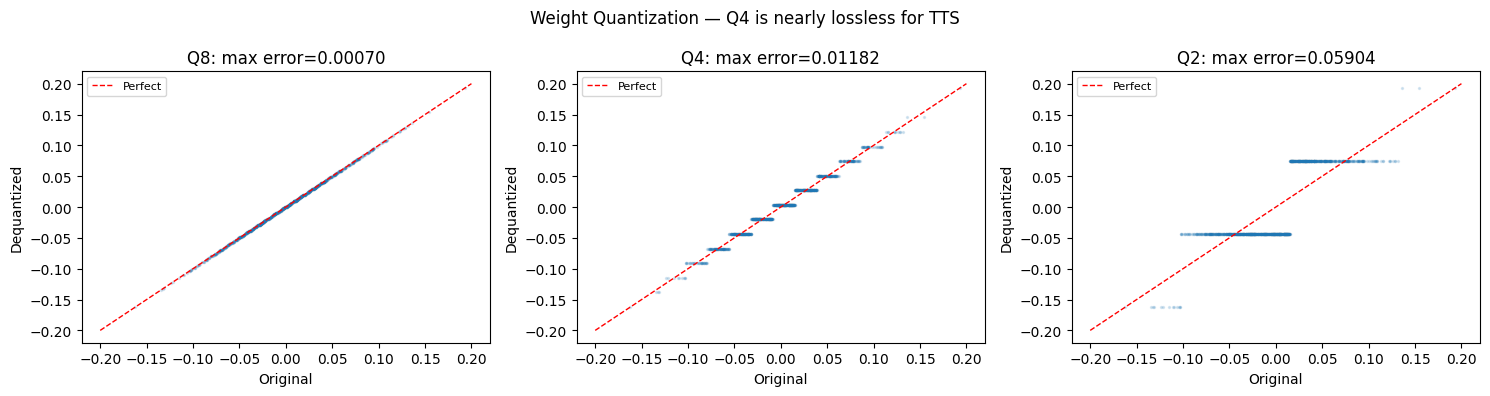

In [10]:
def quantize(weights, bits):
    w_min, w_max = weights.min(), weights.max()
    n_levels = 2**bits
    scale = (w_max - w_min) / (n_levels - 1)
    q = np.round((weights - w_min) / scale).astype(np.int32)
    deq = q * scale + w_min
    return deq, np.abs(weights - deq)

np.random.seed(42)
weights = np.random.randn(1000) * 0.05

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, bits in zip(axes, [8, 4, 2]):
    deq, err = quantize(weights, bits)
    ax.scatter(weights, deq, alpha=0.15, s=2)
    ax.plot([-0.2, 0.2], [-0.2, 0.2], 'r--', lw=1, label="Perfect")
    ax.set_title(f"Q{bits}: max error={err.max():.5f}")
    ax.set_xlabel("Original"); ax.set_ylabel("Dequantized")
    ax.legend(fontsize=8)
plt.suptitle("Weight Quantization — Q4 is nearly lossless for TTS")
plt.tight_layout(); plt.show()

## 2. Memory Footprint by Format

In [11]:
rows = []
for model_name, params_M in [("VieNeu-TTS-0.3B", 300), ("VieNeu-TTS-0.5B", 500)]:
    for fmt, bits in [("fp32", 32), ("fp16", 16), ("Q8", 8), ("Q4", 4)]:
        gb = params_M * 1e6 * (bits/8) / 1e9
        total = gb + 0.05  # codec
        rows.append({
            "Model": model_name, "Format": fmt,
            "Backbone (GB)": f"{gb:.2f}",
            "Total w/ codec": f"{total:.2f}",
            "Fits 8GB RAM": "Yes" if total < 8 else "No",
            "Fits 16GB RAM": "Yes" if total < 16 else "No",
        })

df = pd.DataFrame(rows)
print(df.to_string(index=False))

          Model Format Backbone (GB) Total w/ codec Fits 8GB RAM Fits 16GB RAM
VieNeu-TTS-0.3B   fp32          1.20           1.25          Yes           Yes
VieNeu-TTS-0.3B   fp16          0.60           0.65          Yes           Yes
VieNeu-TTS-0.3B     Q8          0.30           0.35          Yes           Yes
VieNeu-TTS-0.3B     Q4          0.15           0.20          Yes           Yes
VieNeu-TTS-0.5B   fp32          2.00           2.05          Yes           Yes
VieNeu-TTS-0.5B   fp16          1.00           1.05          Yes           Yes
VieNeu-TTS-0.5B     Q8          0.50           0.55          Yes           Yes
VieNeu-TTS-0.5B     Q4          0.25           0.30          Yes           Yes


## 3. RTF Benchmark

In [12]:
from vieneu import Vieneu

test_texts = [
    "Xin ch\u00e0o.",
    "H\u00f4m nay th\u1eddi ti\u1ebft r\u1ea5t \u0111\u1eb9p, t\u00f4i mu\u1ed1n \u0111i d\u1ea1o.",
    "Tr\u00ed tu\u1ec7 nh\u00e2n t\u1ea1o \u0111ang ph\u00e1t tri\u1ec3n nhanh ch\u00f3ng v\u00e0 thay \u0111\u1ed5i nhi\u1ec1u ng\u00e0nh c\u00f4ng nghi\u1ec7p.",
]

tts = Vieneu()
results = []
for text in test_texts:
    times = []
    for _ in range(2):
        t0 = time.time()
        audio = tts.infer(text)
        times.append(time.time() - t0)
    avg = np.mean(times)
    dur = len(audio) / 24000
    rtf = avg / dur
    results.append({
        "Text": text[:45] + ("..." if len(text)>45 else ""),
        "Audio (s)": f"{dur:.2f}",
        "Infer (s)": f"{avg:.2f}",
        "RTF": f"{rtf:.2f}x",
        "Real-time": "Yes" if rtf < 1.0 else "No"
    })
tts.close()

df = pd.DataFrame(results)
print(df.to_string(index=False))
print("\nRTF < 1.0 = faster than real-time")

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `hf_hub_download`. Downloads always resume whenever possible.
  warnings.warn(


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

   📢 Loaded 6 voices from voices.json
   ⚠️ No reference provided. Using default voice: Binh
   ⚠️ No reference provided. Using default voice: Binh
   ⚠️ No reference provided. Using default voice: Binh
   ⚠️ No reference provided. Using default voice: Binh
   ⚠️ No reference provided. Using default voice: Binh
   ⚠️ No reference provided. Using default voice: Binh
                                            Text Audio (s) Infer (s)   RTF Real-time
                                       Xin chào.      1.16      3.14 2.71x        No
     Hôm nay thời tiết rất đẹp, tôi muốn đi dạo.      3.18      6.44 2.02x        No
Trí tuệ nhân tạo đang phát triển nhanh chóng ...      3.72      8.16 2.19x        No

RTF < 1.0 = faster than real-time


## 4. Streaming Inference — First-Chunk Latency

In [13]:
from vieneu import Vieneu
import numpy as np
from IPython.display import Audio, display

tts = Vieneu()
text = "Tr\u00ed tu\u1ec7 nh\u00e2n t\u1ea1o \u0111ang thay \u0111\u1ed5i c\u00e1ch ch\u00fang ta giao ti\u1ebfp h\u00e0ng ng\u00e0y."
voice = tts.get_preset_voice("Binh")

chunks = []
chunk_times = []
t_start = time.time()

for chunk in tts.infer_stream(text, voice=voice):
    t_chunk = time.time() - t_start
    chunk_times.append(t_chunk)
    chunks.append(chunk)
    print(f"Chunk {len(chunks):2d}: {len(chunk)/24000:.2f}s audio at t={t_chunk:.2f}s")

full_audio = np.concatenate(chunks)
print(f"\nFirst-chunk latency: {chunk_times[0]:.2f}s")
print(f"Total audio: {len(full_audio)/24000:.2f}s")
display(Audio(full_audio, rate=24000))
tts.close()

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `hf_hub_download`. Downloads always resume whenever possible.
  warnings.warn(


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

   📢 Loaded 6 voices from voices.json
Chunk  1: 0.50s audio at t=3.31s
Chunk  2: 0.50s audio at t=5.18s
Chunk  3: 0.50s audio at t=7.04s
Chunk  4: 0.50s audio at t=8.93s
Chunk  5: 0.50s audio at t=11.65s
Chunk  6: 0.50s audio at t=13.71s
Chunk  7: 0.52s audio at t=15.31s

First-chunk latency: 3.31s
Total audio: 3.52s


## 5. Packaging voices.json

In [14]:
import torch, librosa
from neucodec import DistillNeuCodec

device = "cuda" if torch.cuda.is_available() else "cpu"
codec = DistillNeuCodec.from_pretrained("neuphonic/distill-neucodec").to(device).eval()

ref_path = str(EXAMPLES_DIR / "example.wav")
ref_text = open(str(EXAMPLES_DIR / "example.txt")).read().strip()

wav, sr = librosa.load(ref_path, sr=16000, mono=True)
wav_t = torch.from_numpy(wav).float().unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    codes = codec.encode_code(wav_t).squeeze().cpu().numpy().flatten().tolist()

voices_json = {
    "default_voice": "example_voice",
    "presets": {
        "example_voice": {
            "codes": [int(c) for c in codes],
            "text": ref_text,
            "description": "Example Vietnamese voice"
        }
    }
}

print("voices.json structure:")
print(f"  default_voice: {voices_json['default_voice']}")
print(f"  text: {ref_text[:60]}...")
print(f"  codes[:10]: {voices_json['presets']['example_voice']['codes'][:10]}")
print(f"  total tokens: {len(codes)}")
print(f"\nWith this file, users can run:")
print("  tts = Vieneu(backbone_repo='your-username/your-model')")
print("  audio = tts.infer('Xin chao!')  # no ref_audio needed")

Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

voices.json structure:
  default_voice: example_voice
  text: ví dụ 2. tính trung bình của dãy số....
  codes[:10]: [1146, 2167, 2231, 35031, 58438, 31442, 30304, 30391, 15162, 47799]
  total tokens: 124

With this file, users can run:
  tts = Vieneu(backbone_repo='your-username/your-model')
  audio = tts.infer('Xin chao!')  # no ref_audio needed


## 6. Production Deployment Checklist

| Category | Check |
|----------|-------|
| **Model** | Use GGUF Q4 for CPU deployment |
| **Model** | Merge LoRA before distributing |
| **Model** | Bundle voices.json on HuggingFace |
| **Quality** | Test all 6 Vietnamese tones |
| **Quality** | Test code-switching (Vietnamese + English) |
| **Quality** | UTMOS > 3.8 on test sentences |
| **Quality** | Human MOS on 30+ sentences |
| **Performance** | RTF < 1.0 on target hardware |
| **Serving** | Use streaming for conversational apps |
| **Serving** | Set max_chars=256 for natural chunking |

## Course Complete!

You have now covered the full end-to-end VieNeu-TTS pipeline:

```
Audio Fundamentals → Text Processing → TTS Architectures → Neural Codecs
                                                                    ↓
                                                           LLM-Based TTS
                                                           ↙           ↘
                                                  Voice Cloning    LoRA Theory
                                                                        ↓
                                                               Data Preparation
                                                                        ↓
                                                          Training & Evaluation
                                                                        ↓
                                                                  Deployment
```

**Next steps:**
1. Collect your Vietnamese audio dataset (Chapter 8)
2. Run the fine-tuning pipeline (Chapter 9)
3. Deploy your custom model (Chapter 10)
4. Contribute to the VieNeu-TTS community!